### Intro
Data set below contains data about results of marketing companies in terms of hypermarket chains. Marketing companies lasted about one month.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.stats.power as smp
from scipy import stats
import seaborn as sns


df = pd.read_csv('Marketing_Campaign.csv')
df.head(10)

C:\Users\Nikita\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
5,1,Medium,2,5,2,2,34.67
6,1,Medium,2,5,2,3,27.98
7,1,Medium,2,5,2,4,27.72
8,1,Medium,3,12,1,1,44.54
9,1,Medium,3,12,1,2,37.94


### Descriptive analysis

We can start from descriptive analysis to see what are distributions of variables, how marketing companies effect on sales in terms of other measures.

#### 1. Sales amount and count of markets in terms of market id   

As we can see, that  count of markets between market_id is comparable, also as amount of sales (except comparison of sales amount between 'large' group)

In [2]:
df.groupby(['MarketID', 'MarketSize']).agg({'LocationID': 'nunique', 'SalesInThousands': 'sum'}).rename(
    columns={'LocationID':'Markets_count'}).sort_values(by=['MarketSize', 'SalesInThousands'],ascending=False)

,,Markets_count,SalesInThousands
MarketID,MarketSize,,
4,Small,9,1962.29
2,Small,6,1482.27
5,Medium,15,2930.28
7,Medium,15,2668.52
8,Medium,12,2349.74
6,Medium,15,2183.85
9,Medium,10,2117.63
1,Medium,13,1825.29
3,Large,22,7477.51


#### 2. Sales amount in terms of market size and market id
Only markets which are included into medium market size group have the same structure of sales by promotions (except 5 market id)

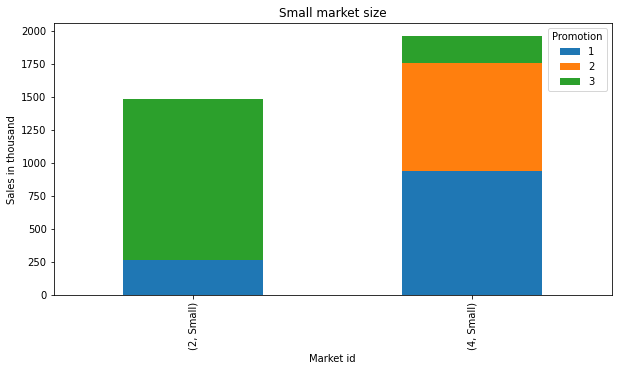

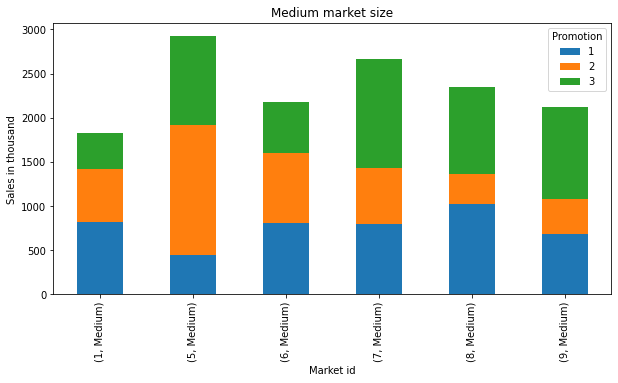

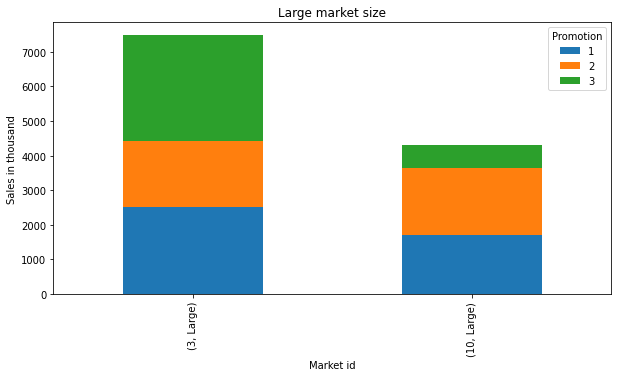

In [3]:
ax = df.groupby(['MarketID', 'MarketSize', 'Promotion']) \
    .sum()['SalesInThousands'] \
    .unstack('Promotion')

market_size_list = ['Small', 'Medium', 'Large']

for ms in market_size_list:
    ax.loc[(slice(None), ms), :].plot(kind='bar', stacked=True, figsize=(10, 5))
    plt.xlabel('Market id')
    plt.ylabel('Sales in thousand')
    plt.title(f'{ms} market size')

#### 3. Sales amount in terms of market size and number of week
There is no different in structure of sales by weeks and market size.

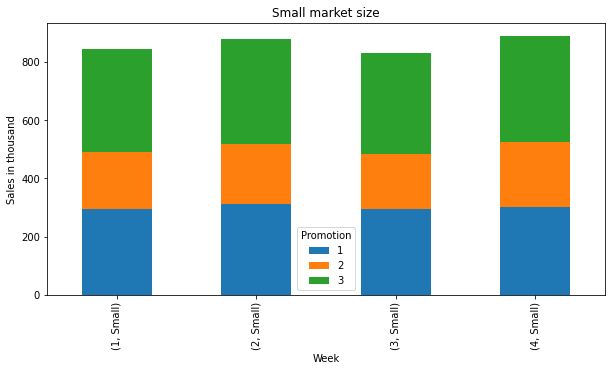

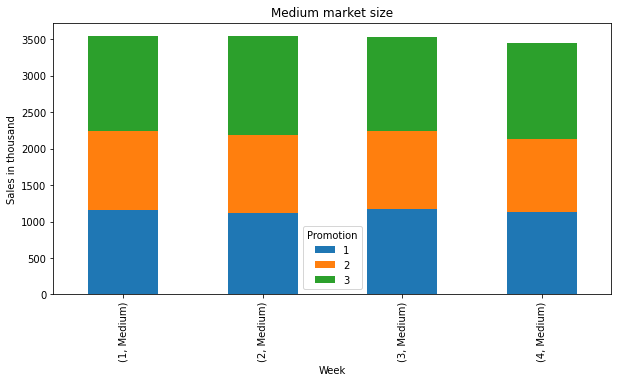

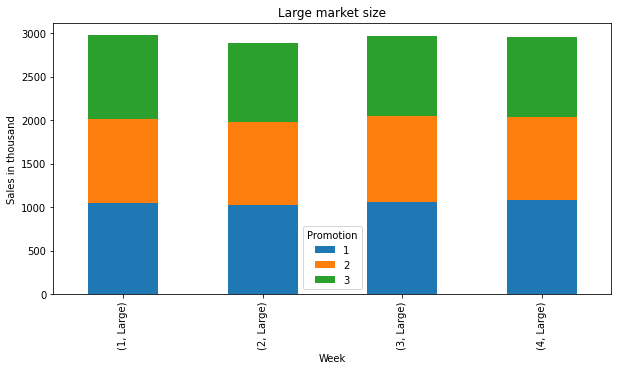

In [4]:
ax = df.groupby(['week', 'MarketSize', 'Promotion']) \
    .sum()['SalesInThousands'] \
    .unstack('Promotion')

market_size_list = ['Small', 'Medium', 'Large']

for ms in market_size_list:
    ax.loc[(slice(None), ms), :].plot(kind='bar', stacked=True, figsize=(10, 5))
    plt.xlabel('Week')
    plt.ylabel('Sales in thousand')
    plt.title(f'{ms} market size')

### A/B Testing


The goal of current a/b test is define, which promotion is good for certain market size, using comparison between average sales by promotions.

#### 1.  'Large' market size
We will start from 'large' market size. Given the fact, that sample size for any promo is greater than fifty, we don't need to check distribution of target variable (sales by week) for normality (due to CLT). We will use one tailed t-test to check significance of differences in means by promotions.
##### Notes
We can receive only 73% of power for single test with alpha 15% and 58% of power for multiple test (count = 2), using Bonferroni correction (calculations are shown below). So, we will not use multiple test here.  
***Regarding the a/b test:***  
we will compare means of promotion groups as follows:   
H<sub>0</sub>: m<sub>0</sub> = m<sub>1</sub>   
H<sub>1</sub>  : m<sub>0</sub> < m<sub>1</sub>  

In [5]:
prom_1_n = df.groupby(['MarketSize', 'Promotion']).count()[['MarketID']].query('MarketSize == "Large" & Promotion == 1') \
            .MarketID.values[0]
prom_2_n = df.groupby(['MarketSize', 'Promotion']).count()[['MarketID']].query('MarketSize == "Large" & Promotion == 2') \
            .MarketID.values[0]
prom_3_n = df.groupby(['MarketSize', 'Promotion']).count()[['MarketID']].query('MarketSize == "Large" & Promotion == 3') \
            .MarketID.values[0]

print(f'Sample size for the first promo is {prom_1_n}')
print(f'Sample size for the second promo is {prom_2_n}')
print(f'Sample size for the third promo is {prom_3_n}')
print()
print(df.groupby(['MarketSize', 'Promotion']).mean()[['SalesInThousands']].query('MarketSize == "Large"')
      .rename(columns={'SalesInThousands': 'mean'}))
print()


# Calculating of effect size
temp_n = 50
temp_std = df.groupby(['MarketSize', 'Promotion']).std()[['SalesInThousands']].query('MarketSize == "Large"').mean().values[0]
uplift = 5
# Cohen's d method
effect_size = uplift / temp_std

# Calculating of test power
ttest_power = smp.TTestIndPower()
power_single_test = ttest_power.solve_power(effect_size=effect_size, nobs1=temp_n, alpha=0.15, power=None, alternative='larger')
power_multiple_test = ttest_power.solve_power(effect_size=effect_size, nobs1=temp_n, alpha=0.15 / 2, power=None, 
                                              alternative='larger')

print(f'Power of single test is {power_single_test:.2f}')
print(f'Power of multiple test is {power_multiple_test:.2f}')
print()


##################################################### implementation of ttest ##################################################
# sampling
promo1_data = df[(df['MarketSize'] == 'Large') & (df['Promotion'] == 1)]['SalesInThousands']
promo2_data = df[(df['MarketSize'] == 'Large') & (df['Promotion'] == 2)]['SalesInThousands']
promo3_data = df[(df['MarketSize'] == 'Large') & (df['Promotion'] == 3)]['SalesInThousands']


#  comparison between promo 1 and promo 2
t_stat, p_value = stats.ttest_ind(promo2_data, promo1_data, equal_var=False, alternative='less')
print(f'T statistic of comparison between promo 1 and promo 2 is {t_stat:.3f}, also p-value is {p_value:.5f}')
print()


#  comparison between promo 3 and promo 2
t_stat, p_value = stats.ttest_ind(promo2_data, promo3_data, equal_var=False, alternative='less')
print(f'T statistic of comparison between promo 3 and promo 2 is {t_stat:.3f}, also p-value is {p_value:.5f}')
print()


#  comparison between promo 3 and promo 1
t_stat, p_value = stats.ttest_ind(promo1_data, promo3_data, equal_var=False, alternative='less')
print(f'T statistic of comparison between promo 3 and promo 1 is {t_stat:.3f}, also p-value is {p_value:.5f}')

Sample size for the first promo is 56
Sample size for the second promo is 64
Sample size for the third promo is 48

                           mean
MarketSize Promotion           
Large      1          75.235893
           2          60.322031
           3          77.203958

Power of single test is 0.73
Power of multiple test is 0.58

T statistic of comparison between promo 1 and promo 2 is -5.223, also p-value is 0.00000

T statistic of comparison between promo 3 and promo 2 is -5.901, also p-value is 0.00000

T statistic of comparison between promo 3 and promo 1 is -0.671, also p-value is 0.25195


##### Results
There are significant differences between mean of sales by promotions:
promo 1 is statistically significant than promo 2, also promo 3 is is statistically significant than promo 2. These result have large values of t-statistic and p-value goes to zero. Comparison of promo 3 and promo 1 doesn't show a significant result (p-value greater than alpha)

#### 2.  'Medium' market size
Given the fact, that sample size for any promo is greater than hundred, we don't need to check distribution of target variable (sales by week) for normality (due to CLT). We will use one tailed t-test to check significance of differences in means by promotions. We will use one tailed t-test to check significance of differences in means by promotions.
##### Notes
We can receive enough power for single test and multiple test (count = 2) with alpha 5%, using Bonferroni correction (calculations are shown below).    
***Regarding the a/b test:***   
we will compare means of promotion groups as follows:   
H0: m0 = m1   
H1 : m0 < m1

In [6]:
prom_1_n = df.groupby(['MarketSize', 'Promotion']).count()[['MarketID']].query('MarketSize == "Medium" & Promotion == 1') \
            .MarketID.values[0]
prom_2_n = df.groupby(['MarketSize', 'Promotion']).count()[['MarketID']].query('MarketSize == "Medium" & Promotion == 2') \
            .MarketID.values[0]
prom_3_n = df.groupby(['MarketSize', 'Promotion']).count()[['MarketID']].query('MarketSize == "Medium" & Promotion == 3') \
            .MarketID.values[0]

print(f'Sample size for the first promo is {prom_1_n}')
print(f'Sample size for the second promo is {prom_2_n}')
print(f'Sample size for the third promo is {prom_3_n}')
print()
print(df.groupby(['MarketSize', 'Promotion']).mean()[['SalesInThousands']].query('MarketSize == "Medium"')
      .rename(columns={'SalesInThousands': 'mean'}))
print()


# Calculating of effect size
temp_n = 100
temp_std = df.groupby(['MarketSize', 'Promotion']).std()[['SalesInThousands']].query('MarketSize == "Medium"').mean().values[0]
uplift = 4
# Cohen's d method
effect_size = uplift / temp_std

# Calculating of test power
ttest_power = smp.TTestIndPower()
power_single_test = ttest_power.solve_power(effect_size=effect_size, nobs1=temp_n, alpha=0.05, power=None, alternative='larger')
power_multiple_test = ttest_power.solve_power(effect_size=effect_size, nobs1=temp_n, alpha=0.05 / 2, power=None, 
                                              alternative='larger')

print(f'Power of single test is {power_single_test:.2f}')
print(f'Power of multiple test is {power_multiple_test:.2f}')
print()


##################################################### implementation of ttest ##################################################
# sampling
promo1_data = df[(df['MarketSize'] == 'Medium') & (df['Promotion'] == 1)]['SalesInThousands']
promo2_data = df[(df['MarketSize'] == 'Medium') & (df['Promotion'] == 2)]['SalesInThousands']
promo3_data = df[(df['MarketSize'] == 'Medium') & (df['Promotion'] == 3)]['SalesInThousands']


#  comparison between promo 1 and promo 2
t_stat, p_value = stats.ttest_ind(promo2_data, promo1_data, equal_var=False, alternative='less')
print(f'T statistic of comparison between promo 1 and promo 2 is {t_stat:.3f}, also p-value is {p_value:.5f}')
print()


#  comparison between promo 3 and promo 2
t_stat, p_value = stats.ttest_ind(promo2_data, promo3_data, equal_var=False, alternative='less')
print(f'T statistic of comparison between promo 3 and promo 2 is {t_stat:.3f}, also p-value is {p_value:.5f}')
print()


#  comparison between promo 1 and promo 3
t_stat, p_value = stats.ttest_ind(promo3_data, promo1_data, equal_var=False, alternative='less')
print(f'T statistic of comparison between promo 1 and promo 3 is {t_stat:.3f}, also p-value is {p_value:.5f}')

Sample size for the first promo is 96
Sample size for the second promo is 108
Sample size for the third promo is 116

                           mean
MarketSize Promotion           
Medium     1          47.672604
           2          39.114352
           3          45.468879

Power of single test is 0.96
Power of multiple test is 0.92

T statistic of comparison between promo 1 and promo 2 is -7.243, also p-value is 0.00000

T statistic of comparison between promo 3 and promo 2 is -5.611, also p-value is 0.00000

T statistic of comparison between promo 1 and promo 3 is -1.977, also p-value is 0.02469


##### Results
There are significant differences between mean of sales by promotions:
promo 1 is statistically significant than promo 2, also promo 3 is is statistically significant than promo 2. These result have large values of t-statistic and p-value goes to zero. Also, comparison of promo 1 and promo 3 shows a significant result (p-value less than alpha, which is 0.025 (after Bonferroni correction) )

#### 3.  'Small' market size

Sample size for any promo group is about 20, so we should check distribution of target value for normality, we will use  shapiro test. If target value was drawn from a normal distribution, we will use one tailed t-test to check significance of differences in means by promotions, also mannwhitneyu test.
##### Notes
We can receive enough power for single test and multiple test (count = 2) with alpha 10%, using Bonferroni correction (calculations are shown below).    
***Regarding the a/b test:***   
we will compare means of promotion groups as follows:   
H0: m0 = m1   
H1 : m0 < m1

Sample size for the first promo is 20
Sample size for the second promo is 16
Sample size for the third promo is 24

                           mean
MarketSize Promotion           
Small      1          60.162500
           2          50.810625
           3          59.514167



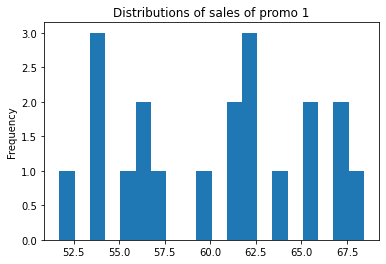

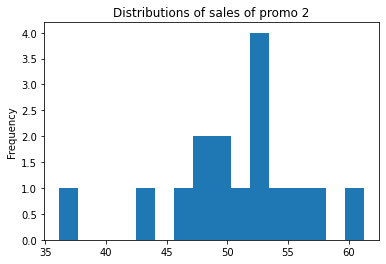

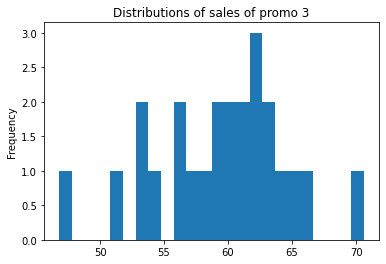

p-value of Shapiro test for promo 1 is 0.319
p-value of Shapiro test for promo 2 is 0.684
p-value of Shapiro test for promo 3 is 0.924

Power of single test is 0.85
Power of multiple test is 0.74

T statistic of comparison between promo 1 and promo 2 is -5.022, also p-value is 0.00001

T statistic of comparison between promo 3 and promo 2 is -4.802, also p-value is 0.00002

T statistic of comparison between promo 1 and promo 3 is -0.414, also p-value is 0.34034

U statistic of comparison between promo 1 and promo 2 is 288.000, also p-value is 0.00002

U statistic of comparison between promo 3 and promo 2 is 338.000, also p-value is 0.00003

U statistic of comparison between promo 1 and promo 3 is 251.500, also p-value is 0.39771



In [7]:
prom_1_n = df.groupby(['MarketSize', 'Promotion']).count()[['MarketID']].query('MarketSize == "Small" & Promotion == 1') \
            .MarketID.values[0]
prom_2_n = df.groupby(['MarketSize', 'Promotion']).count()[['MarketID']].query('MarketSize == "Small" & Promotion == 2') \
            .MarketID.values[0]
prom_3_n = df.groupby(['MarketSize', 'Promotion']).count()[['MarketID']].query('MarketSize == "Small" & Promotion == 3') \
            .MarketID.values[0]

print(f'Sample size for the first promo is {prom_1_n}')
print(f'Sample size for the second promo is {prom_2_n}')
print(f'Sample size for the third promo is {prom_3_n}')
print()

print(df.groupby(['MarketSize', 'Promotion']).mean()[['SalesInThousands']].query('MarketSize == "Small"')
      .rename(columns={'SalesInThousands': 'mean'}))
print()


# sampling
promo1_data = df[(df['MarketSize'] == 'Small') & (df['Promotion'] == 1)]['SalesInThousands']
promo2_data = df[(df['MarketSize'] == 'Small') & (df['Promotion'] == 2)]['SalesInThousands']
promo3_data = df[(df['MarketSize'] == 'Small') & (df['Promotion'] == 3)]['SalesInThousands']


# checking distribution of target variable for normality
promo1_data.plot.hist(bins=prom_1_n)
plt.title('Distributions of sales of promo 1')
plt.show()

promo2_data.plot.hist(bins=prom_2_n)
plt.title('Distributions of sales of promo 2')
plt.show()

promo3_data.plot.hist(bins=prom_3_n)
plt.title('Distributions of sales of promo 3')
plt.show()

stat, p_value = stats.shapiro(promo1_data)
print(f'p-value of Shapiro test for promo 1 is {p_value:.3f}')

stat, p_value = stats.shapiro(promo2_data)
print(f'p-value of Shapiro test for promo 2 is {p_value:.3f}')

stat, p_value = stats.shapiro(promo3_data)
print(f'p-value of Shapiro test for promo 3 is {p_value:.3f}')
print()


# Calculating of effect size
temp_n = 20
temp_std = df.groupby(['MarketSize', 'Promotion']).std()[['SalesInThousands']].query('MarketSize == "Small"').mean().values[0]
uplift = 4
# Cohen's d method
effect_size = uplift / temp_std


# Calculating of test power
ttest_power = smp.TTestIndPower()
power_single_test = ttest_power.solve_power(effect_size=effect_size, nobs1=temp_n, alpha=0.10, power=None, alternative='larger')
power_multiple_test = ttest_power.solve_power(effect_size=effect_size, nobs1=temp_n, alpha=0.10 / 2, power=None, 
                                              alternative='larger')

print(f'Power of single test is {power_single_test:.2f}')
print(f'Power of multiple test is {power_multiple_test:.2f}')
print()


##################################################### implementation of ttest ##################################################

#  comparison between promo 1 and promo 2
t_stat, p_value = stats.ttest_ind(promo2_data, promo1_data, equal_var=False, alternative='less')
print(f'T statistic of comparison between promo 1 and promo 2 is {t_stat:.3f}, also p-value is {p_value:.5f}')
print()


#  comparison between promo 3 and promo 2
t_stat, p_value = stats.ttest_ind(promo2_data, promo3_data, equal_var=False, alternative='less')
print(f'T statistic of comparison between promo 3 and promo 2 is {t_stat:.3f}, also p-value is {p_value:.5f}')
print()


#  comparison between promo 1 and promo 3
t_stat, p_value = stats.ttest_ind(promo3_data, promo1_data, equal_var=False, alternative='less')
print(f'T statistic of comparison between promo 1 and promo 3 is {t_stat:.3f}, also p-value is {p_value:.5f}')
print()


########################################## implementation of nonparametric test (mannwhitneyu)##################################

#  comparison between promo 1 and promo 2
u_stat, p_value = stats.mannwhitneyu(promo1_data, promo2_data, alternative='greater')
print(f'U statistic of comparison between promo 1 and promo 2 is {u_stat:.3f}, also p-value is {p_value:.5f}')
print()

#  comparison between promo 3 and promo 2
u_stat, p_value = stats.mannwhitneyu(promo3_data, promo2_data, alternative='greater')
print(f'U statistic of comparison between promo 3 and promo 2 is {u_stat:.3f}, also p-value is {p_value:.5f}')
print()

#  comparison between promo 1 and promo 3
u_stat, p_value = stats.mannwhitneyu(promo1_data, promo3_data, alternative='greater')
print(f'U statistic of comparison between promo 1 and promo 3 is {u_stat:.3f}, also p-value is {p_value:.5f}')
print()

##### Results
There are significant differences between mean of sales by promotions:
promo 1 is statistically significant than promo 2, also promo 3 is is statistically significant than promo 2. These result have large values of t-statistic and p-value goes to zero. Comparison between promo 3 and promo 1 doesn't show a significant result (p-value greater than alpha).    
Also, Mannwhitneyu test shows the same results as t-test.